In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, BatchNormalization
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [2]:
currency_name = 'USDCHF'

In [3]:
df = pd.read_parquet('../Dataframes/df_' + currency_name + '.parquet.gzip')

In [4]:
df.head()

,date,open,high,low,close,delta,wclose,so_3,so_4,so_5,...,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg,slope_3,slope_4,slope_5,slope_10,slope_20,slope_30
29,11/2/2000,1.6300,1.6399,1.6250,1.6249,1.0,1.628675,38.775510,35.714286,31.147541,...,1.63610,1.62045,1.628275,1.63245,-63.291139,114.634146,157.664421,110.250338,265.287832,308.454864
30,14/2/2000,1.6249,1.6448,1.6195,1.6436,0.0,1.637875,95.847751,95.918367,95.918367,...,1.64235,1.62225,1.632300,1.63215,-54.725040,-69.204152,-47.049967,-109.331018,-104.924041,281.429476
31,15/2/2000,1.6436,1.6441,1.6285,1.6360,0.0,1.636150,65.217391,69.550173,70.068027,...,1.64445,1.62400,1.634225,1.63630,-57.639367,-69.557204,-85.433575,-142.527407,-260.857926,253.726418
32,16/2/2000,1.6360,1.6397,1.6248,1.6255,0.0,1.628875,23.715415,23.715415,33.217993,...,1.64190,1.62665,1.634275,1.63225,185.439560,-61.368123,-81.751409,-143.873133,-323.442110,235.882283
33,17/2/2000,1.6255,1.6303,1.6112,1.6235,1.0,1.622125,37.386018,36.607143,36.607143,...,1.63500,1.61800,1.626500,1.62075,58.750389,76.897372,18.979064,-63.840049,-282.907225,234.920784


In [5]:
# swap high price and opening price

# now the second column is now daily high price

def swap_columns(df, c1, c2):
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df.rename(columns={c1: c2, c2: c1}, inplace=True)
    
swap_columns(df, 'open', 'high')

In [6]:
df.drop(columns=['delta'],inplace=True)

In [7]:
df.head()

,date,high,open,low,close,wclose,so_3,so_4,so_5,so_8,...,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg,slope_3,slope_4,slope_5,slope_10,slope_20,slope_30
29,11/2/2000,1.6399,1.6300,1.6250,1.6249,1.628675,38.775510,35.714286,31.147541,20.925110,...,1.63610,1.62045,1.628275,1.63245,-63.291139,114.634146,157.664421,110.250338,265.287832,308.454864
30,14/2/2000,1.6448,1.6249,1.6195,1.6436,1.637875,95.847751,95.918367,95.918367,63.228700,...,1.64235,1.62225,1.632300,1.63215,-54.725040,-69.204152,-47.049967,-109.331018,-104.924041,281.429476
31,15/2/2000,1.6441,1.6436,1.6285,1.6360,1.636150,65.217391,69.550173,70.068027,62.424242,...,1.64445,1.62400,1.634225,1.63630,-57.639367,-69.557204,-85.433575,-142.527407,-260.857926,253.726418
32,16/2/2000,1.6397,1.6360,1.6248,1.6255,1.628875,23.715415,23.715415,33.217993,33.114754,...,1.64190,1.62665,1.634275,1.63225,185.439560,-61.368123,-81.751409,-143.873133,-323.442110,235.882283
33,17/2/2000,1.6303,1.6255,1.6112,1.6235,1.622125,37.386018,36.607143,36.607143,36.607143,...,1.63500,1.61800,1.626500,1.62075,58.750389,76.897372,18.979064,-63.840049,-282.907225,234.920784


### Change the normalization to be (0, 1)

In [8]:
data = df

# constants
lookback = 50
batch_size = 512
epoch = 10

# 30% of the data used for testing
test_size = int(.1 * (len(data)-lookback))


# feed the lstm with all features starting from the open price
# still contains the high
input_features = data.iloc[:, 1:].values
input_data = input_features

# train a numpy array of input vectors
sc = MinMaxScaler(feature_range = (0, 1))

input_data[:,:] = sc.fit_transform(input_features[:,:])

In [9]:
input_features

array([[0.82676878, 0.82525418, 0.83120529, ..., 0.49289595, 0.51460105,
        0.57009764],
       [0.83123632, 0.82062455, 0.82622476, ..., 0.43744105, 0.39666733,
        0.56254543],
       [0.8305981 , 0.83759985, 0.83437472, ..., 0.42905736, 0.34699344,
        0.55480385],
       ...,
       [0.22811816, 0.23384168, 0.24531377, ..., 0.72743589, 0.38842426,
        0.17882   ],
       [0.22775346, 0.2369281 , 0.24721543, ..., 0.67004293, 0.41831697,
        0.18448124],
       [0.22802699, 0.2369281 , 0.24694377, ..., 0.47490574, 0.33465773,
        0.18172556]])

In [10]:
input_data.shape

(5183, 33)

In [11]:
# number of features excluding the target feature
feature_size = input_data.shape[1] - 1
feature_size

32

In [12]:
input_data

array([[0.82676878, 0.82525418, 0.83120529, ..., 0.49289595, 0.51460105,
        0.57009764],
       [0.83123632, 0.82062455, 0.82622476, ..., 0.43744105, 0.39666733,
        0.56254543],
       [0.8305981 , 0.83759985, 0.83437472, ..., 0.42905736, 0.34699344,
        0.55480385],
       ...,
       [0.22811816, 0.23384168, 0.24531377, ..., 0.72743589, 0.38842426,
        0.17882   ],
       [0.22775346, 0.2369281 , 0.24721543, ..., 0.67004293, 0.41831697,
        0.18448124],
       [0.22802699, 0.2369281 , 0.24694377, ..., 0.47490574, 0.33465773,
        0.18172556]])

In [13]:
input_data[[0],1:]

array([[0.82525418, 0.83120529, 0.82062455, 0.823912  , 0.62133851,
        0.52655526, 0.48871637, 0.39486381, 0.38751258, 0.37090276,
        0.47235961, 0.42507645, 0.39486381, 0.38751258, 0.37090276,
        0.54427889, 0.52354031, 0.53421216, 0.51659715, 0.83733562,
        0.82125428, 0.5346943 , 0.82390519, 0.82927609, 0.82660873,
        0.8281357 , 0.66385373, 0.72441526, 0.35868918, 0.49289595,
        0.51460105, 0.57009764]])

In [14]:
'''
package data into packs of 50 each, starting from the oldest data
up to len(data) - test_size - lookback - 1

X is excluded from the daily high price: the target value

and convert X and y to numpy array
'''
X = []
y = []
for i in range(len(data)- lookback):
    t = []
    for j in range(lookback):
        t.append(input_data[[(i + j)], 1:])
    X.append(t)
    y.append(input_data[i + lookback, 0])

X, y = np.array(X), np.array(y)

In [15]:
X

array([[[[0.82525418, 0.83120529, 0.82062455, ..., 0.49289595,
          0.51460105, 0.57009764]],

        [[0.82062455, 0.82622476, 0.83759985, ..., 0.43744105,
          0.39666733, 0.56254543]],

        [[0.83759985, 0.83437472, 0.8307008 , ..., 0.42905736,
          0.34699344, 0.55480385]],

        ...,

        [[0.84204793, 0.85239518, 0.8595679 , ..., 0.43295715,
          0.38282111, 0.54148874]],

        [[0.8595679 , 0.86235624, 0.86120189, ..., 0.42941396,
          0.36971959, 0.52536896]],

        [[0.86120189, 0.86923843, 0.86701162, ..., 0.43063029,
          0.36707392, 0.50474853]]],


       [[[0.82062455, 0.82622476, 0.83759985, ..., 0.43744105,
          0.39666733, 0.56254543]],

        [[0.83759985, 0.83437472, 0.8307008 , ..., 0.42905736,
          0.34699344, 0.55480385]],

        [[0.8307008 , 0.83102418, 0.82116921, ..., 0.4287175 ,
          0.32705679, 0.54981733]],

        ...,

        [[0.8595679 , 0.86235624, 0.86120189, ..., 0.42941396,
       

In [16]:
# test data taken from the latest (size - (test_size + lookback)) data points
X_test = X[-test_size:]

# cut the test data out
X = X[:-(test_size)]
y = y[:-(test_size)]

# reshape
X = X.reshape(X.shape[0], lookback, feature_size)
X_test = X_test.reshape(X_test.shape[0],lookback, feature_size)
X.shape

(4620, 50, 32)

In [17]:
file = "./Models/" + currency_name + ".model"
model = None
if os.path.exists(file):
    model = load_model(file)
else:
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],feature_size)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32)
    model.save(file)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            7560      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 22,231
Trainable params: 22,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4620/4620 [==============================] - 10s 2ms/step - loss: 0.0067
Epoch 2/5
4620/4620 [==============================] - 9s 2ms/step - loss: 2.7313e-04
Epoch 3/5
4620/4620 [==============================] - 8s 2ms/step - loss: 1.99

In [18]:
# put the predicted target value inside input_data

# inverse tranform the predicted data

predicted_value = model.predict(X_test)
li = input_data.shape[0]
lp = predicted_value.shape[0]
for i in range(li - lp, li - 1):
    input_data[i + 1][0] = predicted_value[i - (li - lp)][0]

input_data = sc.inverse_transform(input_data)

input_data = input_data[-(test_size) + 1:,0]

In [19]:
actual_data = data.iloc[:, 1:].values[-(test_size) + 1:,0]
actual_data

array([0.9784, 0.9842, 0.9846, 0.9816, 0.9771, 0.9685, 0.9665, 0.9659,
       0.9668, 0.9641, 0.964 , 0.9634, 0.9582, 0.9467, 0.9432, 0.9387,
       0.9394, 0.9359, 0.9342, 0.9337, 0.9377, 0.9398, 0.9455, 0.947 ,
       0.9409, 0.9407, 0.9399, 0.9375, 0.9296, 0.9288, 0.932 , 0.937 ,
       0.9397, 0.9409, 0.9374, 0.9391, 0.9417, 0.9458, 0.9491, 0.9424,
       0.9408, 0.9419, 0.9443, 0.952 , 0.9535, 0.9514, 0.9494, 0.948 ,
       0.952 , 0.9548, 0.9552, 0.957 , 0.9567, 0.9515, 0.9497, 0.9489,
       0.9509, 0.9578, 0.9584, 0.9566, 0.9565, 0.9597, 0.9612, 0.964 ,
       0.9649, 0.961 , 0.9581, 0.9597, 0.9646, 0.9639, 0.9637, 0.9678,
       0.9699, 0.9724, 0.976 , 0.9789, 0.981 , 0.9848, 0.9896, 0.992 ,
       0.9921, 0.997 , 1.    , 0.9999, 1.0023, 1.0056, 1.0045, 1.0056,
       1.0057, 1.004 , 1.0008, 1.0042, 1.0019, 1.0033, 1.0018, 1.0002,
       0.9991, 0.9978, 0.9958, 0.9937, 0.9958, 0.9983, 0.9935, 0.9897,
       0.9913, 0.9894, 0.9893, 0.9886, 0.9868, 0.9888, 0.9874, 0.9884,
      

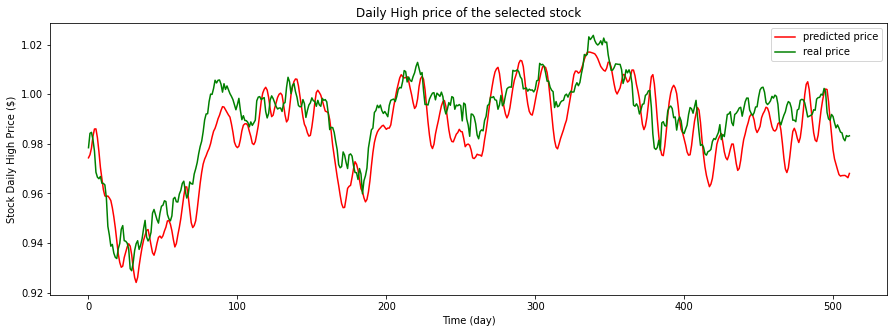

In [20]:
plt.figure(figsize=(15,5))
plt.plot(input_data, color= 'red', label="predicted price")
plt.plot(actual_data, color='green', label="real price")
plt.title("Daily High price of the selected stock")
plt.xlabel("Time (day)")
plt.ylabel("Stock Daily High Price ($)")

plt.legend()

In [21]:
# generate alphas
frame = pd.DataFrame({'actual': actual_data, 'predict': input_data})

In [22]:
frame['p1'] = frame['predict'].shift(1)
frame['diff1'] = frame['predict'] - frame['p1']
frame

,actual,predict,p1,diff1
0,0.9784,0.974322,NaN,NaN
1,0.9842,0.975570,0.974322,0.001248
2,0.9846,0.978242,0.975570,0.002672
3,0.9816,0.982967,0.978242,0.004725
4,0.9771,0.985934,0.982967,0.002967
...,...,...,...,...
507,0.9821,0.967215,0.967158,0.000057
508,0.9812,0.967229,0.967215,0.000014
509,0.9833,0.966830,0.967229,-0.000399
510,0.9829,0.966302,0.966830,-0.000529


In [23]:
frame['alpha'] = frame['diff1'] / frame['actual'] * 200

In [24]:
frame['wclose'] = data['wclose'].values[-(test_size) + 1:]
frame['pct_change'] = frame['wclose'].pct_change()
frame.head(10)

,actual,predict,p1,diff1,alpha,wclose,pct_change
0,0.9784,0.974322,NaN,NaN,NaN,0.976800,NaN
1,0.9842,0.975570,0.974322,0.001248,0.253580,0.981700,0.005016
2,0.9846,0.978242,0.975570,0.002672,0.542781,0.979125,-0.002623
3,0.9816,0.982967,0.978242,0.004725,0.962727,0.976600,-0.002579
4,0.9771,0.985934,0.982967,0.002967,0.607384,0.969925,-0.006835
5,0.9685,0.985988,0.985934,0.000054,0.011181,0.963750,-0.006366
6,0.9665,0.982400,0.985988,-0.003589,-0.742579,0.960900,-0.002957
7,0.9659,0.976857,0.982400,-0.005542,-1.147629,0.963800,0.003018
8,0.9668,0.970468,0.976857,-0.006389,-1.321640,0.960525,-0.003398
9,0.9641,0.965900,0.970468,-0.004568,-0.947633,0.959925,-0.000625


In [25]:
capital = 100000
frame['capital_allocation'] = frame['alpha'] * capital
frame['daily_pnl'] = frame['capital_allocation'] * frame['pct_change']

In [26]:
cumsum = frame['daily_pnl'].cumsum()

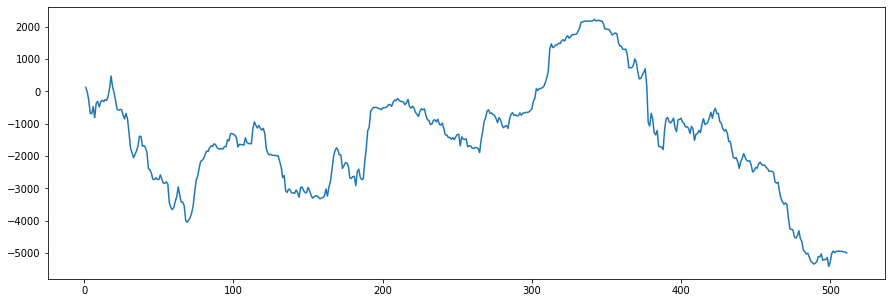

In [27]:
plt.figure(figsize=(15,5))
plt.plot(cumsum)
plt.show()

In [28]:
# calculate sharpe ratio

sharpe = np.sqrt(252) * (frame['daily_pnl'].mean()) / (frame['daily_pnl'].std())
sharpe

-0.8926155813868971

In [29]:
# calculate win/loss ratio

wins = 0
losses = 0

length = frame['daily_pnl'].count()

for i in range(length):
    if frame['daily_pnl'][i] > 0:
        wins += 1
    elif frame['daily_pnl'][i] < 0:
        losses += 1

wl = wins / losses
wl

0.8782287822878229

In [30]:
# maximum drawdown
maxm = 0
drawdown = 0
cur_low = 0
size = len(cumsum)

final_start = 0
final_end = 0

start_date = 0
end_date = 0

for i in range(1, size):
    cur_val = cumsum[i]
    if cur_val >= maxm:
        
        drawdown = max(drawdown, maxm - cur_low)
        
        if drawdown == maxm - cur_low:
            final_start = start_date
            final_end = end_date
            
        maxm = cur_val
        cur_low = cur_val
        
        start_date = i
    else:
        cur_low = min(cur_low, cur_val)
        if cur_low == cur_val:
            end_date = i

print('drawdown is:', drawdown, ', from day', final_start, ', to day', final_end)

drawdown is: 4528.025518752258 , from day 18 , to day 69
